In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import pyregion
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, FK5
import astropy.units as u
from scipy import stats

import sys
sys.path.append('../B5_NOEMA_30m')
from B5setup import *

import velocity_tools.stream_lines as SL

In [2]:
def get_streamer(mass, r0, theta0, phi0, omega0, v_r0, inc, PA):
    (x1, y1, z1), (vx1, vy1, vz1) = SL.xyz_stream(
        mass=mass, r0=r0, theta0=theta0, phi0=phi0,
        omega=omega0, v_r0=v_r0, inc=inc, pa=PA, rmin=500*u.au) #, deltar=10*u.au)
    # we obtain the distance of each point in the sky
    d_sky_au = np.sqrt(x1**2 + z1**2)
    # Stream line into arcsec
    dra_stream = -x1.value / dist_B5.value
    ddec_stream = z1.value / dist_B5.value
    fil = SkyCoord(dra_stream*u.arcsec, ddec_stream*u.arcsec,
                   frame=B5_ref).transform_to(FK5)
    velocity = v_lsr + vy1
    return fil, d_sky_au, velocity


In [3]:
# parameters for the streamline model 
# Constants
M_star = 0.2 * u.Msun # from our PV diagram analysis
M_disk = 0.025 * u.Msun # corrected from 240 to 302 pc distance from Zapata et al 2014
M_env = 0.21 * u.Msun # From Brassfield and Bourke 2011
Mtot = M_star + M_disk + M_env
v_lsr = 10.2 * u.km/u.s
# inclination and position angle given by the outflow (i=0 is edge on for this setup
# PA=0 lays on west)
inc = (13) * u.deg
PA_ang = (157+90)*u.deg

# reference coordinates
B5_c = SkyCoord(ra_yso*u.deg, dec_yso*u.deg, frame='fk5')
B5_ref = B5_c.skyoffset_frame()

# axes given by i and PA
x_b = np.array([1, 0, 0])*1e3/dist_B5.value
y_b = np.array([0, 0, 0])*1e3/dist_B5.value
z_b = np.array([0, 0, 1])*1e3/dist_B5.value
nx_b, ny_b, nz_b = SL.rotate_xyz(x_b, y_b, z_b, inc=inc, pa=PA_ang)
my_axis_new = SkyCoord(-nx_b*u.arcsec, nz_b*u.arcsec, frame=B5_ref).transform_to(FK5)

# Initial parameters
r0 = 2430 * u.au
theta0 = 106 * u.deg  # rotate clockwise
phi0 = 71 * u.deg
v_r0 = 0.0 * u.km/u.s
omega0 = 3.0e-13 / u.s

fil0, dsky0, velo0 = get_streamer(Mtot, r0, theta0, phi0, omega0, v_r0, inc, PA_ang)


rc=181.98808244943086 AU


In [4]:
# Filenames for H2CO
folder = 'gaussfit_H2CO/'
imagename = folder + 'B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_2_sigmafiltered_Tpeak.fits'
vcname = folder + 'B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_2_sigmafiltered_Vlsr.fits'
regionfile = folder + 'region_kde2.reg'

# Filenames for 12CO
folderco = 'dirty_images/'
vcnameco = folderco + 'B5IRS1_12CO_contsub_dirty_blue_mom1.fits'
regionfileco = folderco + 'region_blue_outflow_cone.reg'


In [5]:
# create the grid for the kernel distribution
# x is projected distance
xmin = 0
xmax = 2000
# y is velocity lsr
ymin = 9
ymax = 11
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
# Here we obtain the kernel density estimation of the velocities along the line of sight for H2CO
r_proj, v_los = get_vc_r(vcname, regionfile, ra_yso*u.deg, dec_yso*u.deg, dist_B5)
# we select only those who are not nan
gd_vlos = np.isfinite(r_proj*v_los)
values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])
# we calculate the kernel distribution
kernelH2CO = stats.gaussian_kde(values)
zzH2CO = np.reshape(kernelH2CO(positions).T, xx.shape)
zzH2CO /= zzH2CO.max()  # normalization of probability

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
# create the grid for the kernel distribution of CO
# y is velocity lsr
yminco = -10
ymaxco = 8
xx, yyco = np.mgrid[xmin:xmax:100j, yminco:ymaxco:100j]
positionsco = np.vstack([xx.ravel(), yyco.ravel()])
# Here we obtain the kernel density estimation of the velocities along the line of sight for CO
r_proj, v_los = get_vc_r(vcnameco, regionfileco, ra_yso*u.deg, dec_yso*u.deg, dist_B5)
# we select only those who are not nan
gd_vlos = np.isfinite(r_proj*v_los)
values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])
# we calculate the kernel distribution
kernelCO = stats.gaussian_kde(values)
zzCO = np.reshape(kernelCO(positionsco).T, xx.shape)
zzCO /= zzCO.max()  # normalization of probability

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


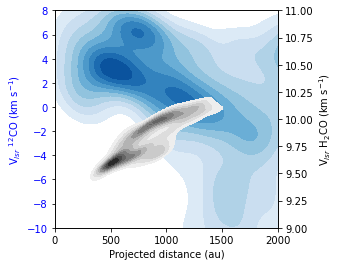

In [9]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111)
ax.contourf(xx, yyco, zzCO, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.set_xlim([xmin,xmax])
ax.set_ylabel(r"V$_{lsr}$ $^{12}$CO (km s$^{-1}$)", color='b')
ax.tick_params(axis='y', labelcolor='b')

ax2 = ax.twinx()
ax.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ H$_2$CO (km s$^{-1}$)")
ax2.set_yticks([9,9.25,9.5,9.75,10,10.25,10.5,10.75,11])
ax2.contourf(xx, yy, zzH2CO, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
# ax2.axhline(10.2, color='k', ls=':')
# ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])

# we add the streamline model
# ax2.plot(dsky0[:150], velo0[:150], color='r')
fig.savefig('comparison_KDE_vel_12CO_H2CO.pdf', bbox_inches='tight')


In [8]:
len(velo0)

193